In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from util_bagging import bagging_het, bagging_het_predict
from scipy.stats import mode

df = pd.read_csv('telecom_churn.csv')

In [5]:
df.head()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   
3      0            84                0         0        0.0              2   
4      0            75                0         0        0.0              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1

In [6]:
def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6), plot_type='hist', target='', fontsize=10):
    nrows = df.shape[1]//ncols
    if nrows*ncols < df.shape[1]:
        nrows += 1

    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

    i = 0
    for idx, (colname, serie) in enumerate(df.items()):
        j = (idx % ncols)
        ax[i,j].set_title(colname, fontsize=fontsize)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

        if (serie.dtype == 'object') or (
            serie.dtype == 'int64' and serie.unique().shape[0] <= max_discrete):
            serie = serie.value_counts().sort_values(ascending=True)
            ax_aux = ax[i,j].barh(
                y=np.array(serie.index).astype('str'),
                width=serie.values,
            )
        else:
            if plot_type == 'hist':
                ax[i,j].hist(x=serie, color='xkcd:sunflower', density=True)
                ax[i,j].axvline(x=np.mean(serie), color='xkcd:fuchsia', ls='--', lw=0.8)
            elif plot_type == 'boxplot':
                ax[i,j].boxplot(serie)
                ax[i,j].set_xticklabels([''])

        if (j == ncols-1): i += 1

    plt.tight_layout()
    plt.show()
    
def generate_metrics(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        'Modelo': model_name,
        'Precision': precision_score(y_true, y_pred),
        'Sensibilidad (Recall)': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Casos totales': len(y_true)
    }

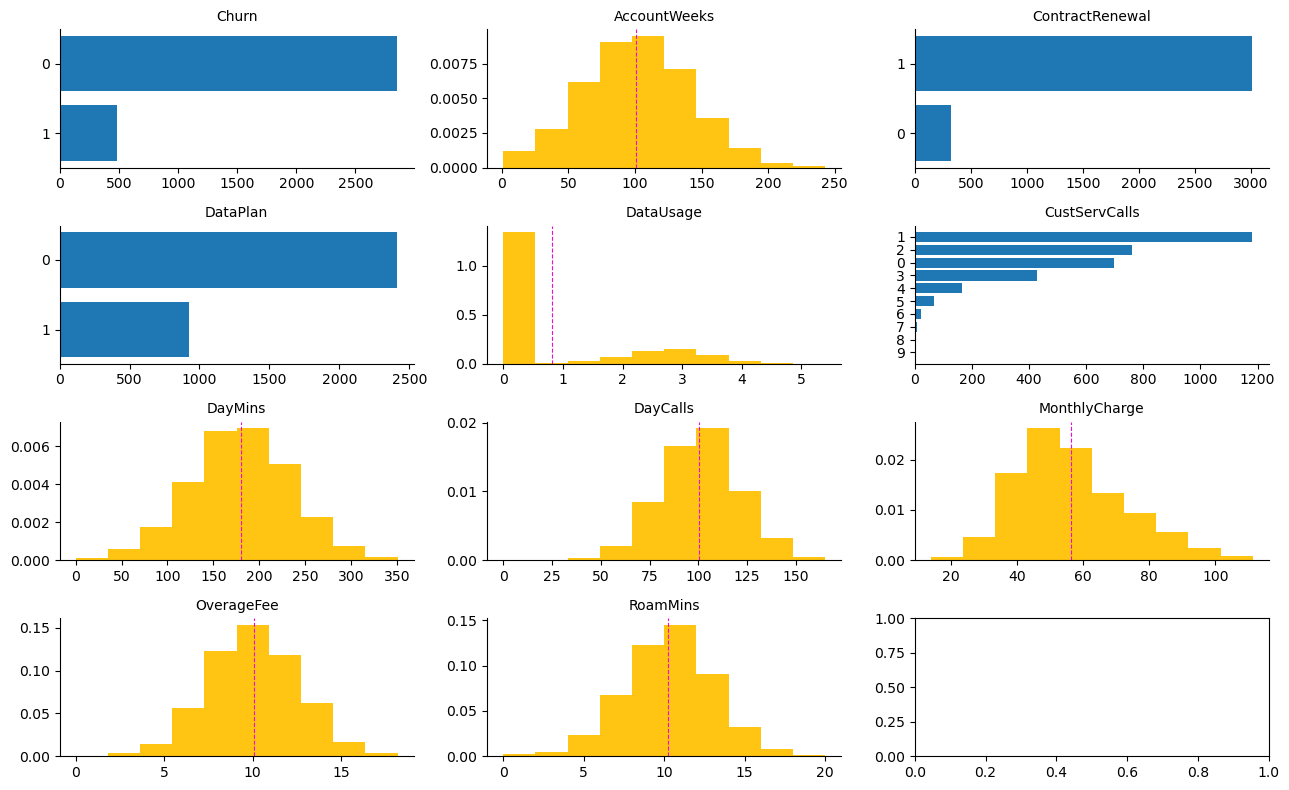

In [7]:
plot_descriptive(df, figsize=(13, 8))

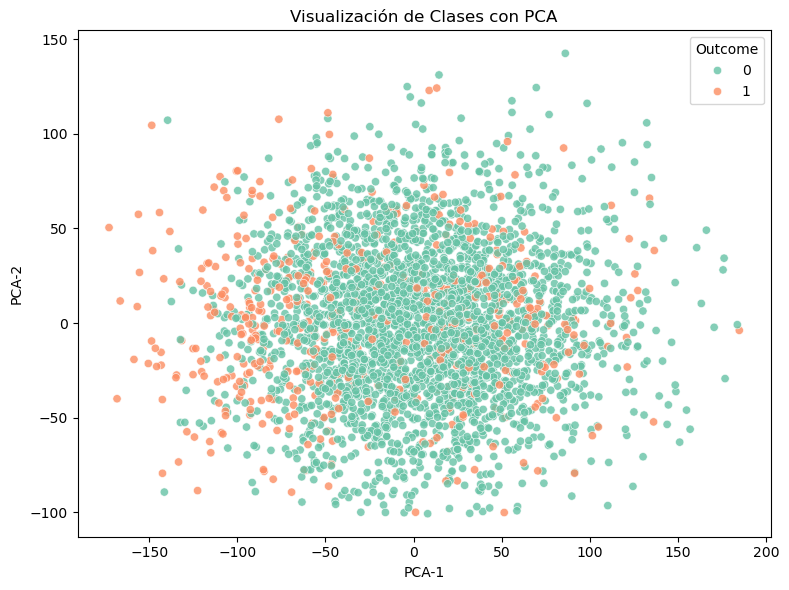

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features = df.drop(columns=['Churn'])
labels = df['Churn']
X_pca = pca.fit_transform(features)
pca_df = pd.DataFrame(X_pca, columns=['PCA-1', 'PCA-2'])
pca_df['Outcome'] = labels.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PCA-1', y='PCA-2', hue='Outcome', palette='Set2', alpha=0.8)
plt.title('Visualización de Clases con PCA')
plt.tight_layout()
plt.show()

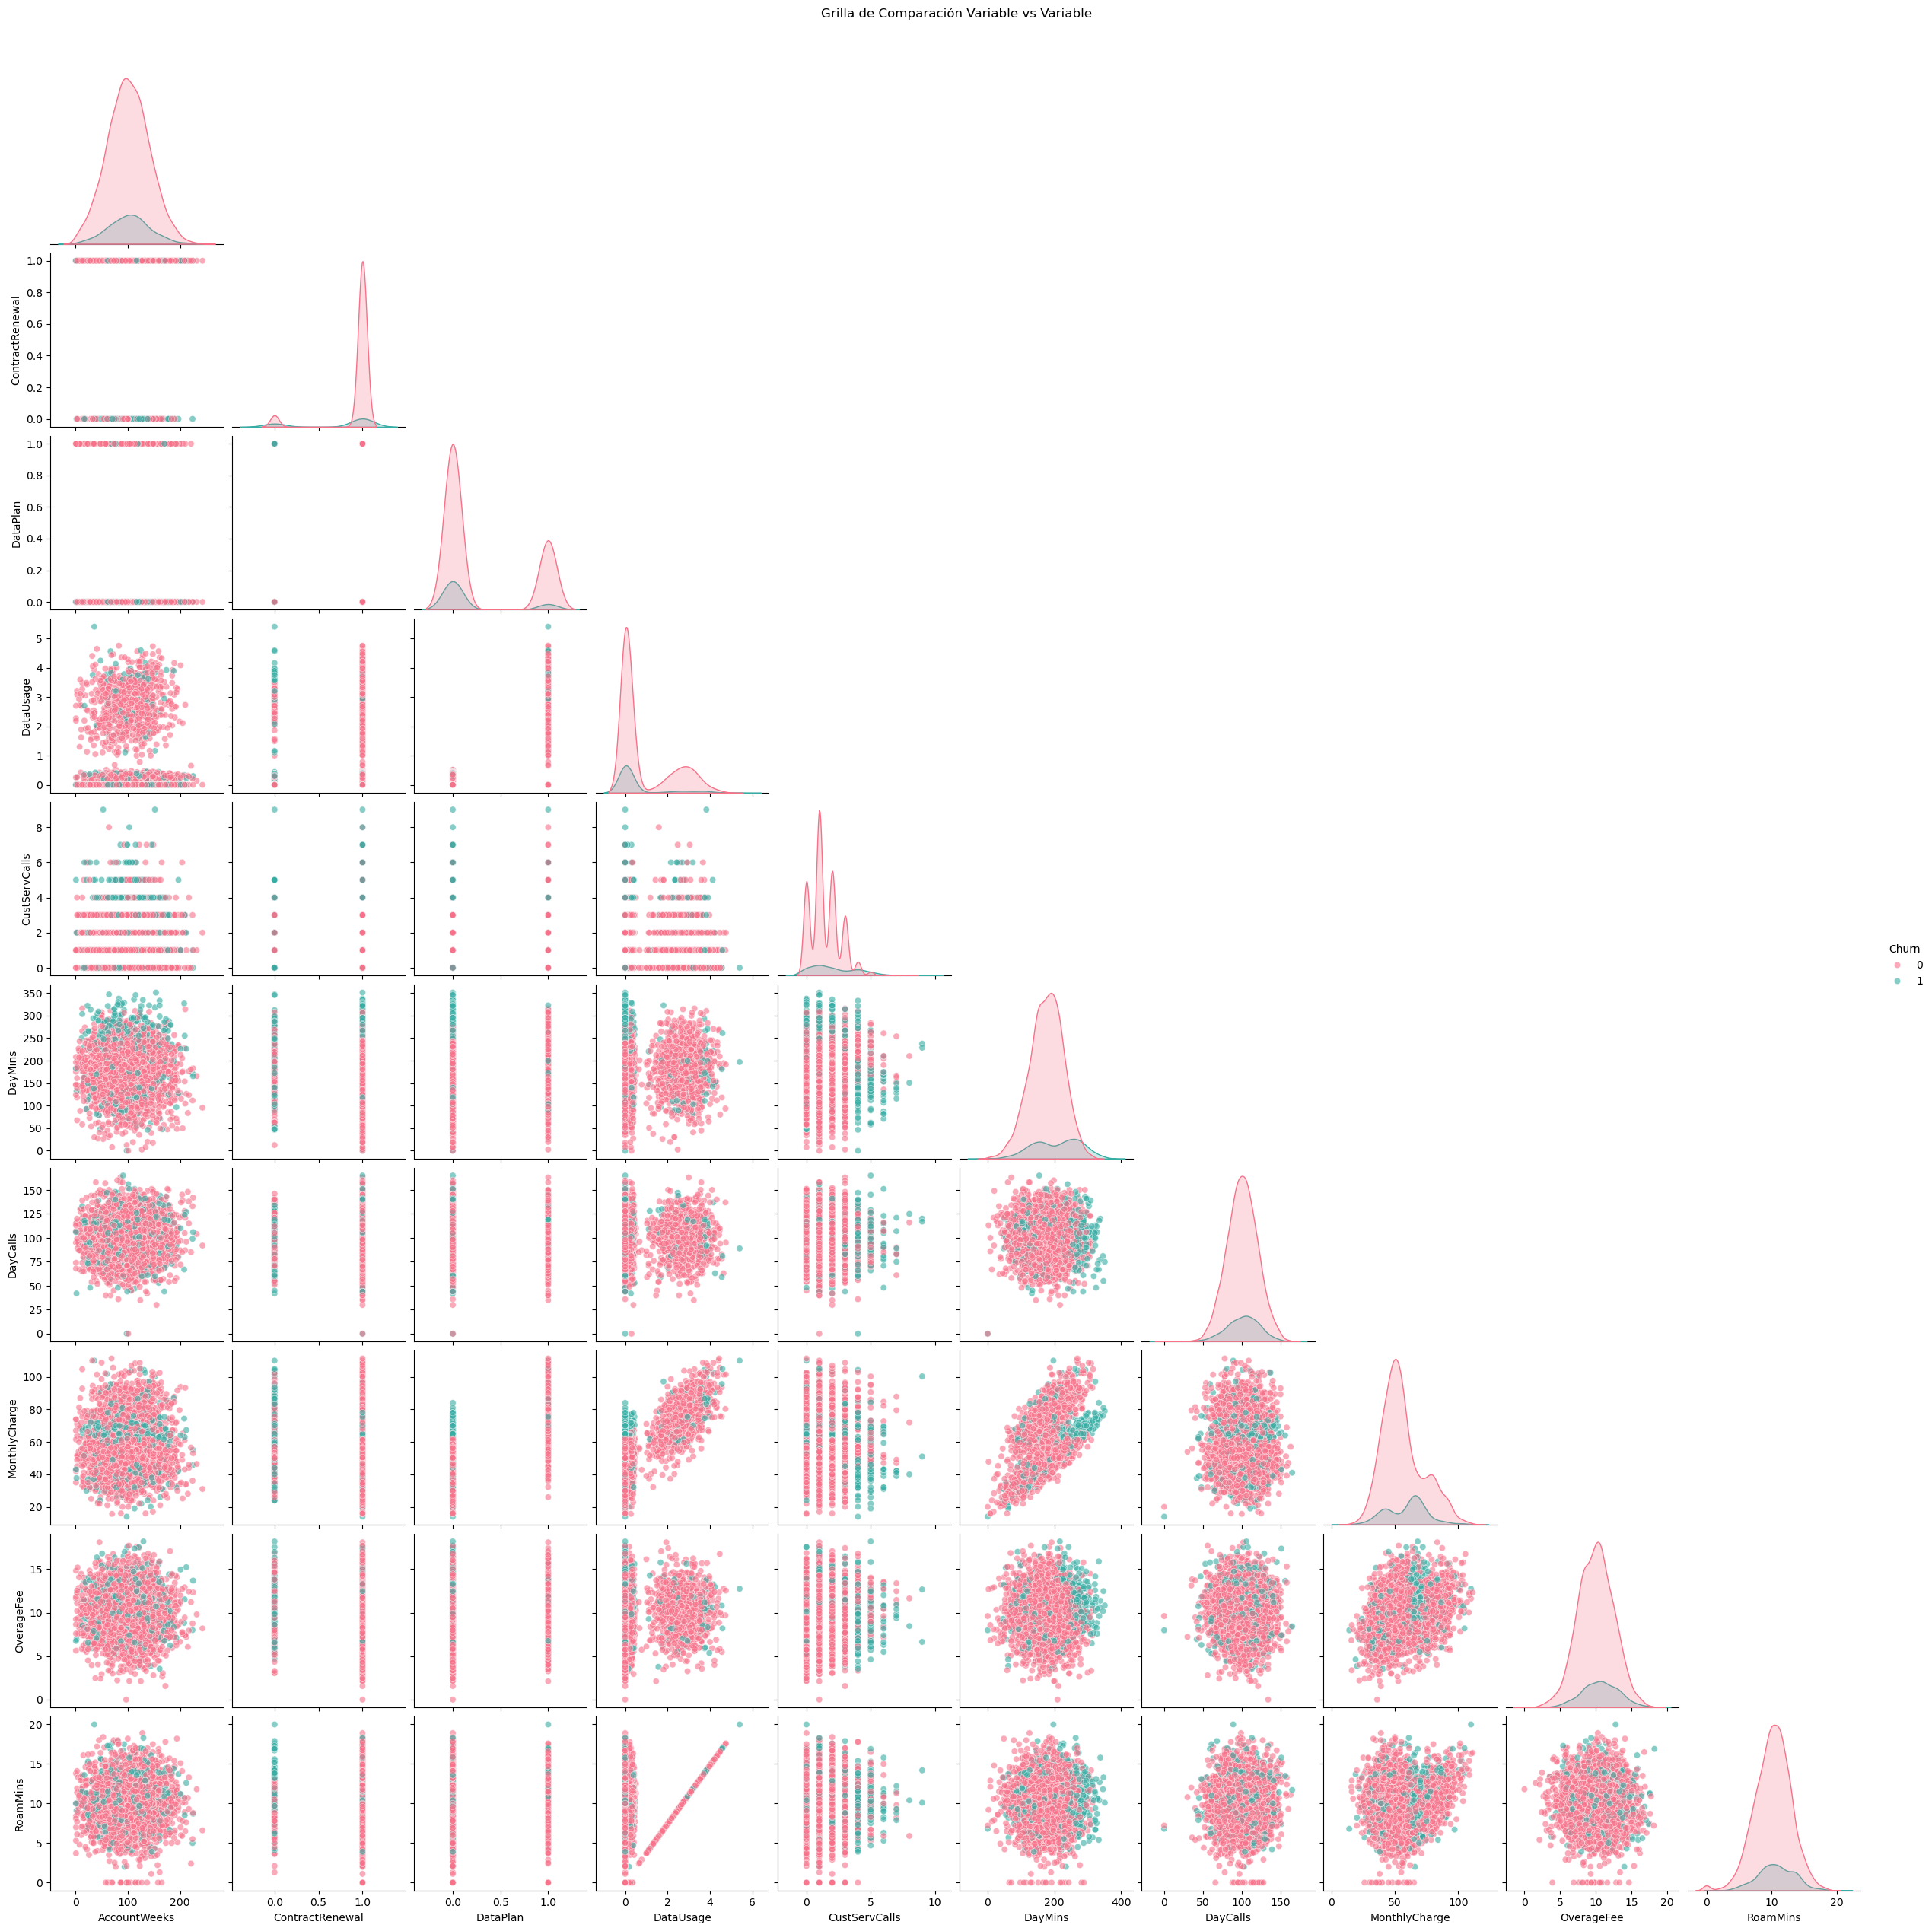

In [14]:
sns.pairplot(df, hue='Churn', palette='husl', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle('Grilla de Comparación Variable vs Variable', y=1.02)
plt.show()

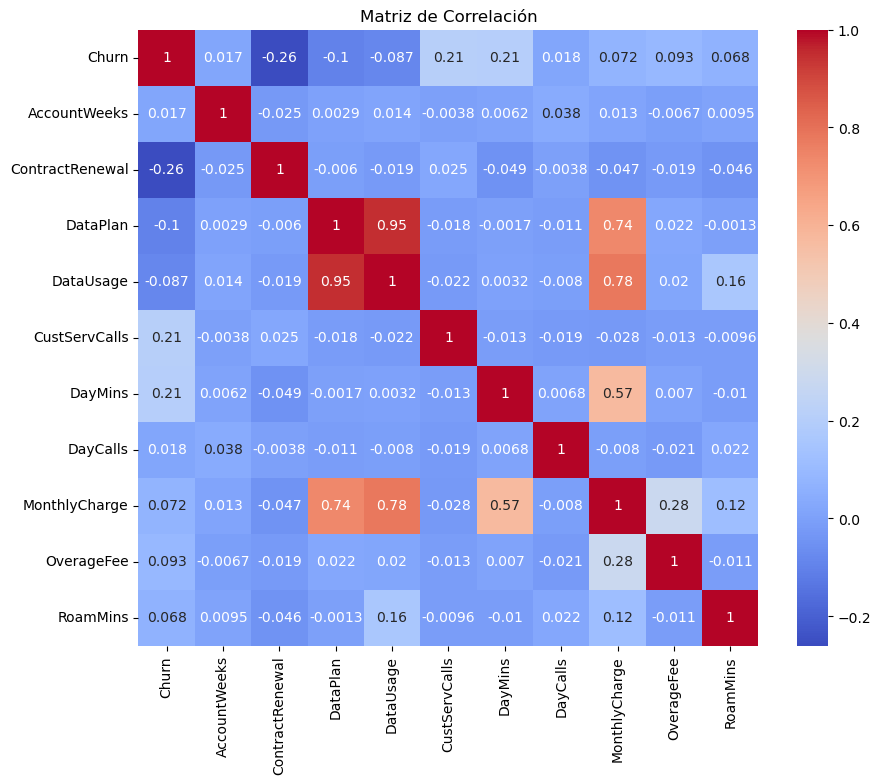

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [16]:
from sklearn.tree import plot_tree
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

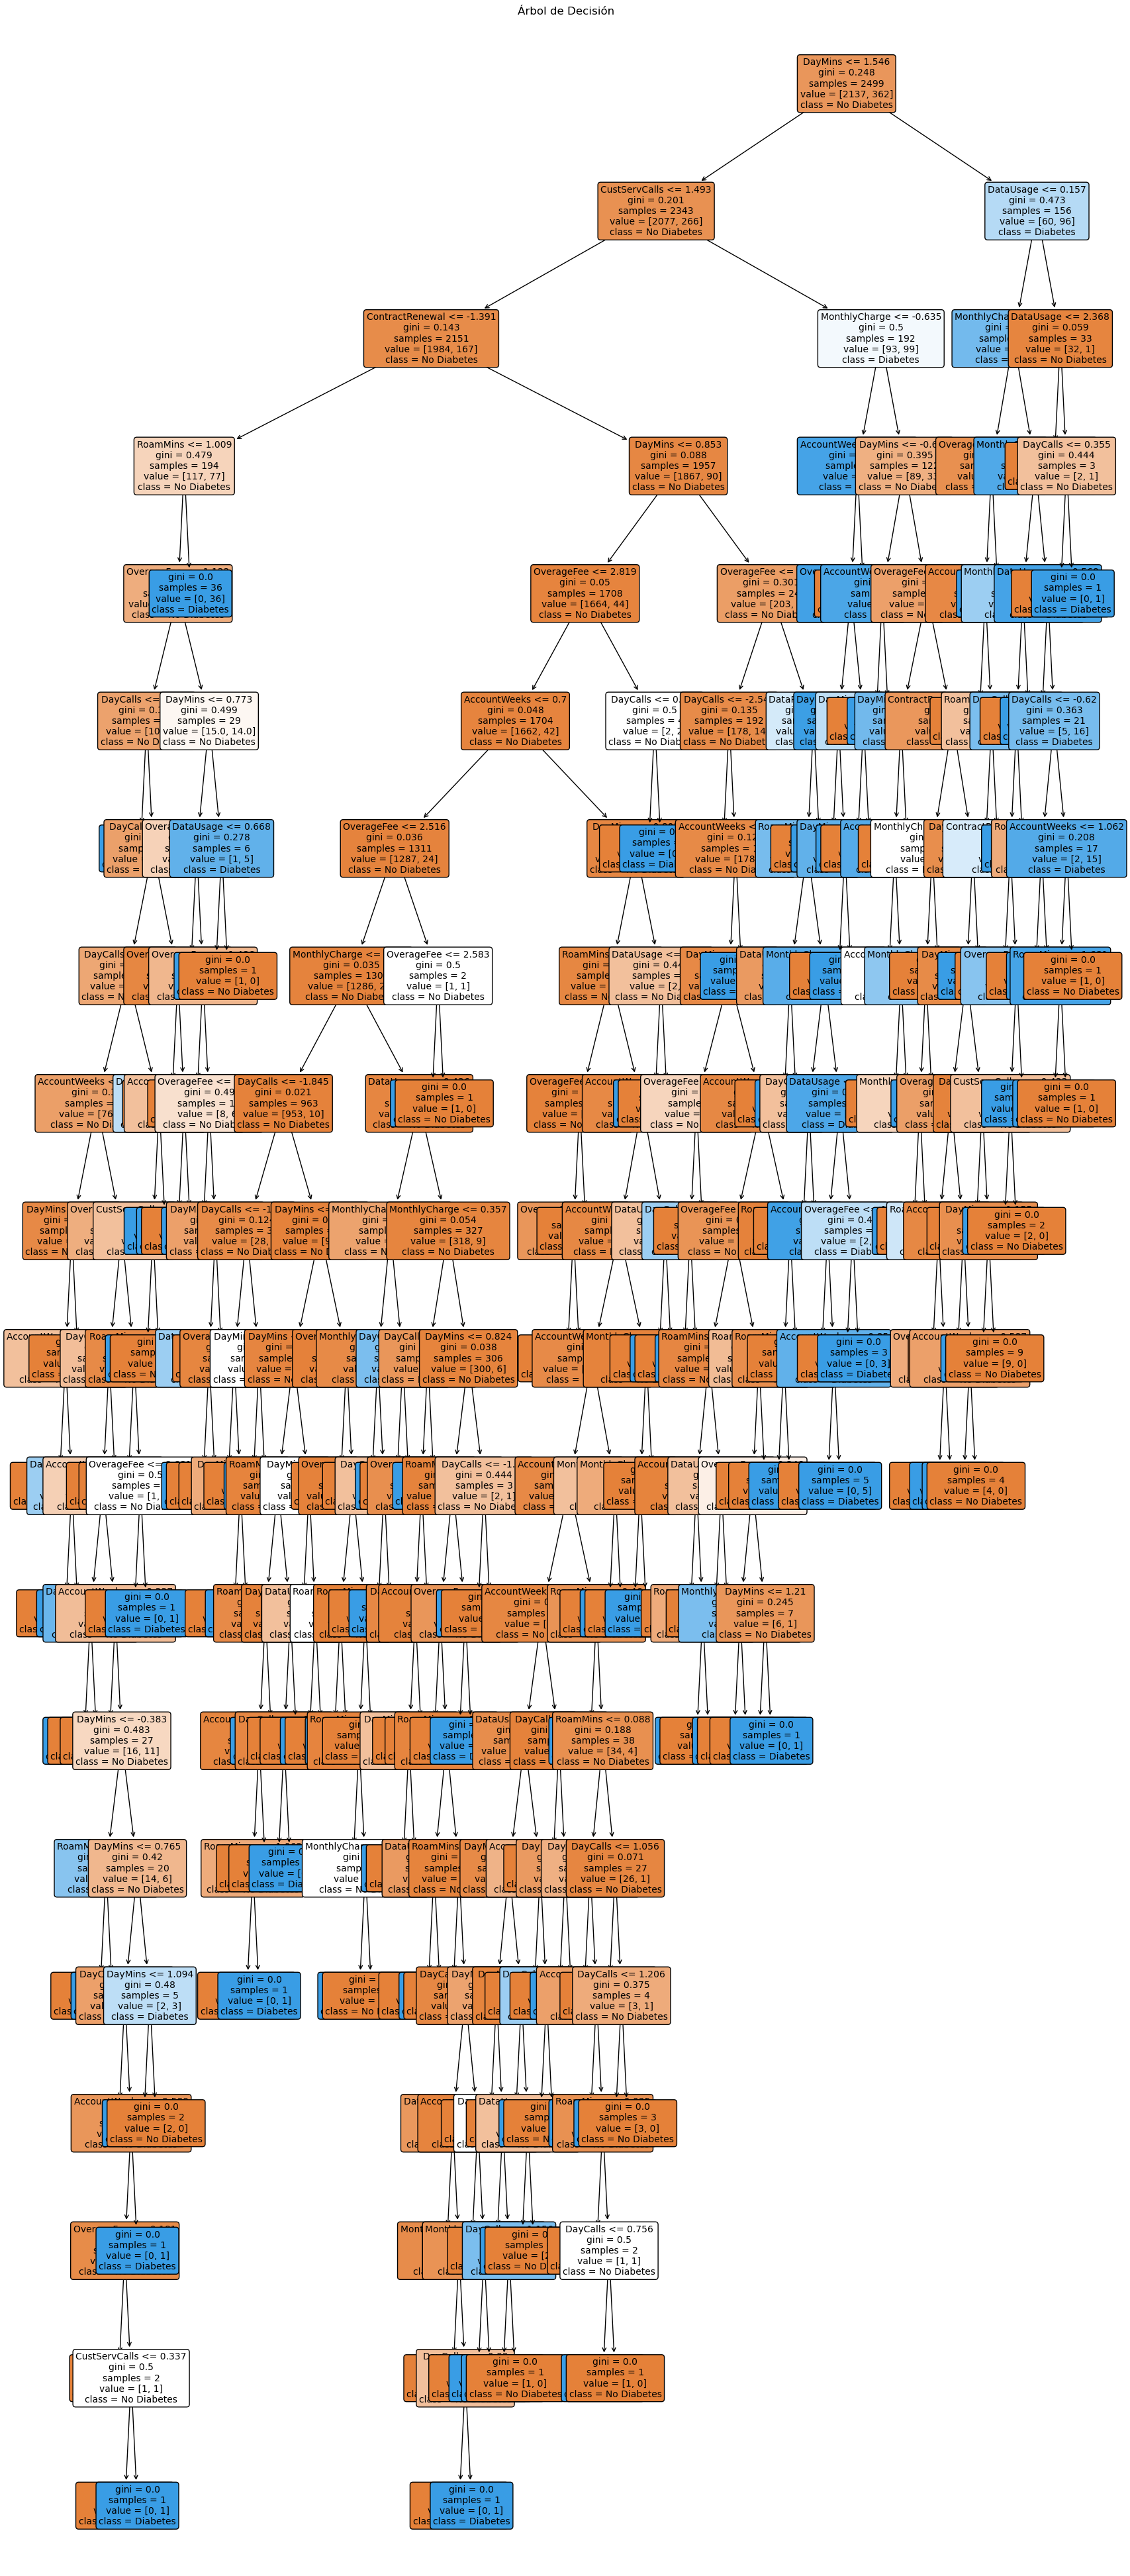

In [17]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
y_proba_tree = tree.predict_proba(X_test_scaled)[:,1]

plt.figure(figsize=(20, 50))
plot_tree(tree, 
          feature_names=X.columns, 
          class_names=['No Diabetes', 'Diabetes'],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Árbol de Decisión")
plt.show()

In [23]:
print("=== Árbol sin tunear ===")
print("Accuracy test:", accuracy_score(y_test, y_pred_tree))
print("ROC AUC test:", roc_auc_score(y_test, y_proba_tree))
print("Classification report:\n", classification_report(y_test, y_pred_tree))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_tree))

=== Árbol sin tunear ===
Accuracy test: 0.8776978417266187
ROC AUC test: 0.7466298842047917
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       713
           1       0.58      0.56      0.57       121

    accuracy                           0.88       834
   macro avg       0.75      0.75      0.75       834
weighted avg       0.88      0.88      0.88       834

Confusion matrix:
 [[664  49]
 [ 53  68]]


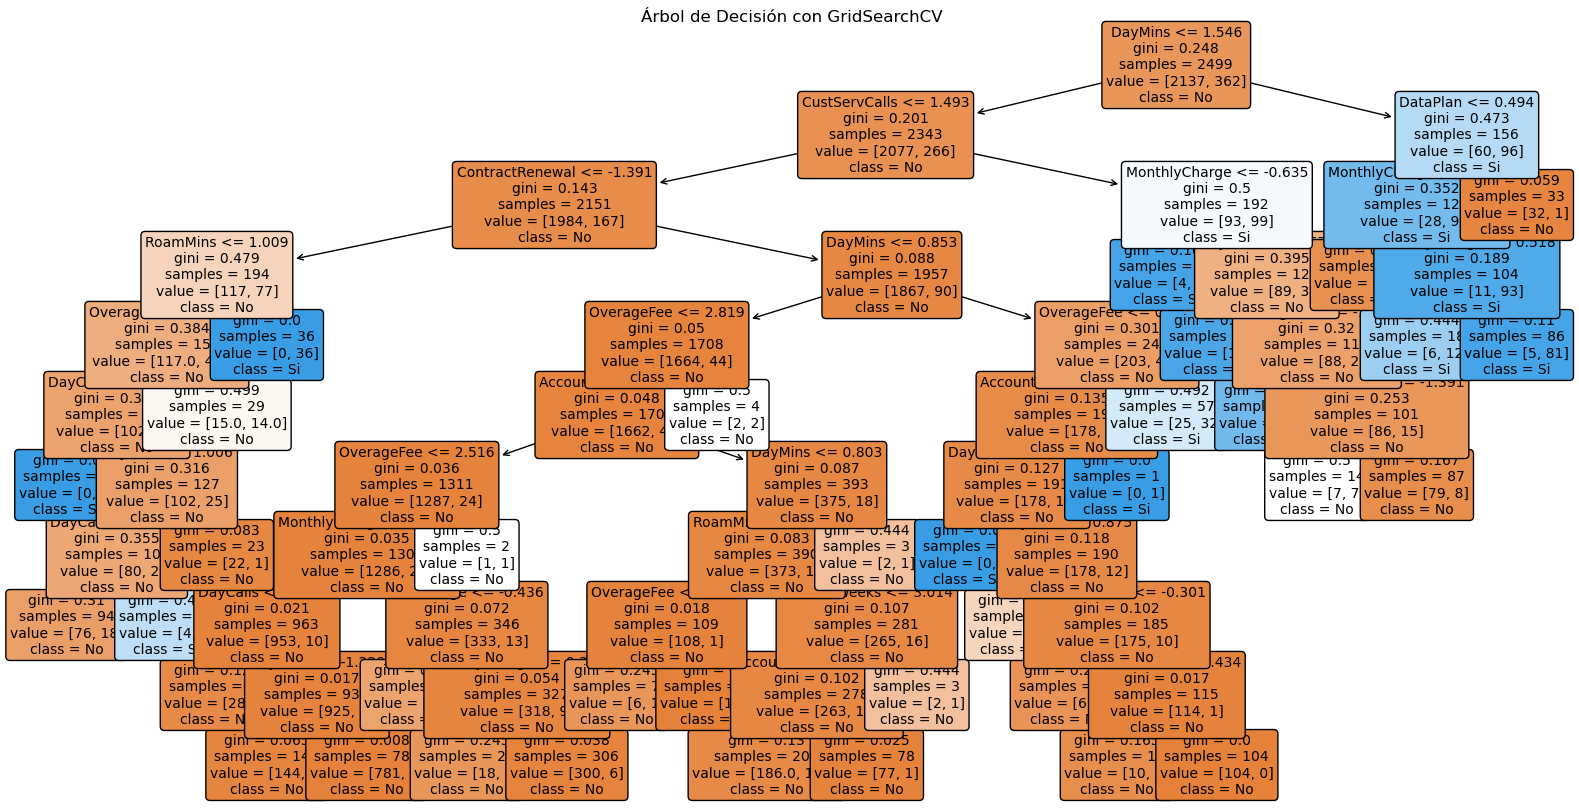

In [28]:
params_tree= {'max_depth': [5, 10, 15,20,25], 'min_samples_split':[0.01, 0.02, 0.03, 0.04]}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), params_tree, cv=5)
grid_tree.fit(X_train_scaled, y_train)
y_pred_tree_cv = best_tree.predict(X_test_scaled)
y_proba_tree_cv = best_tree.predict_proba(X_test_scaled)[:, 1]
y_train_pred_cv = best_tree.predict(X_train_scaled)
y_train_proba_cv = best_tree.predict_proba(X_train_scaled)[:, 1]

plt.figure(figsize=(20, 10))
best_tree = grid_tree.best_estimator_
plot_tree(best_tree,
          feature_names=X.columns,
          class_names=['No', 'Si'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Árbol de Decisión con GridSearchCV")
plt.show()

In [20]:
print("Mejores parámetros encontrados:")
print(grid_tree.best_params_)

Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_split': 0.04}


In [30]:
print("\n=== Árbol con GridSearchCV ===")
print("Mejores hiperparámetros:", grid_tree.best_params_)

print("\n--- Train ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred_cv))
print("ROC AUC:", roc_auc_score(y_train, y_train_proba_cv))

print("\n--- Test ---")
print("Accuracy:", accuracy_score(y_test, y_pred_tree_cv))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tree_cv))
print("Classification report:\n", classification_report(y_test, y_pred_tree_cv))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_tree_cv))


=== Árbol con GridSearchCV ===
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 0.04}

--- Train ---
Accuracy: 0.938375350140056
ROC AUC: 0.9531401484499621

--- Test ---
Accuracy: 0.9064748201438849
ROC AUC: 0.8244410186269169
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       713
           1       0.73      0.56      0.64       121

    accuracy                           0.91       834
   macro avg       0.83      0.76      0.79       834
weighted avg       0.90      0.91      0.90       834

Confusion matrix:
 [[688  25]
 [ 53  68]]


In [31]:
len(X_train_scaled)

2499

In [34]:
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

In [35]:
len(X_train_resampled)

4274

In [38]:
bag = BaggingClassifier(n_estimators=200, random_state=42)
bag.fit(X_res, y_res)
y_pred_bag = bag.predict(X_test_scaled)
y_proba_bag = bag.predict_proba(X_test_scaled)[:,1]

In [39]:
print("=== Bagging con SMOTE y 200 árboles ===")
print("Accuracy test:", accuracy_score(y_test, y_pred_bag))
print("ROC AUC test:", roc_auc_score(y_test, y_proba_bag))
print("Classification report:\n", classification_report(y_test, y_pred_bag))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_bag))

=== Bagging con SMOTE y 200 árboles ===
Accuracy test: 0.894484412470024
ROC AUC test: 0.864360808132324
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       713
           1       0.62      0.69      0.66       121

    accuracy                           0.89       834
   macro avg       0.78      0.81      0.80       834
weighted avg       0.90      0.89      0.90       834

Confusion matrix:
 [[662  51]
 [ 37  84]]


In [40]:
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    SVC(kernel='rbf', probability=True),
    SVC(kernel='sigmoid', probability=True)]

trained_models, yhat_test, yhat_out, idx_oob = bagging_het(
    pd.DataFrame(X_res, columns=X.columns),
    y_res,
    200,
    models,
    pd.DataFrame(X_test_scaled, columns=X.columns)
)
y_proba_het = yhat_test.mean(axis=1)

In [ ]:
y_pred_het = (y_proba_het >= 0.5).astype(int)  # Umbral en 0.5

print("=== Bagging Heterogéneo con 200 Bootstrap ")
print("Accuracy:", accuracy_score(y_test, y_pred_het))
print("ROC AUC:", roc_auc_score(y_test, y_proba_het))
print("Classification Report:\n", classification_report(y_test, y_pred_het))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_het))

=== Bagging Heterogéneo con 200 Bootstrap Samples ===
Accuracy: 0.790167865707434
ROC AUC: 0.8532449317863063
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87       713
           1       0.39      0.80      0.53       121

    accuracy                           0.79       834
   macro avg       0.68      0.79      0.70       834
weighted avg       0.88      0.79      0.82       834

Confusion Matrix:
 [[562 151]
 [ 24  97]]


In [43]:
from sklearn.base import clone
model_names = ["LogReg", "Tree", "SVM-RBF", "SVM-Sigmoid"]
f1_scores = []

for model in models:
    clf = clone(model)
    clf.fit(X_res, y_res)  # Usamos datos con SMOTE
    y_pred = clf.predict(X_test_scaled)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

for name, score in zip(model_names, f1_scores):
    print(f"{name}: F1-score = {score:.4f}")

LogReg: F1-score = 0.4709
Tree: F1-score = 0.6233
SVM-RBF: F1-score = 0.5966
SVM-Sigmoid: F1-score = 0.2597


In [ ]:
best_idx = np.argmax(f1_scores)
best_model = models[best_idx]
print(f"Mejor modelo según F1-score: {model_names[best_idx]}")


models_weighted = models.copy()
models_weighted.append(clone(best_model))

Mejor modelo según F1-score: Tree


In [47]:
trained_models, yhat_test, yhat_out, idx_oob = bagging_het(
    pd.DataFrame(X_train_resampled, columns=X.columns),
    y_res,
    200,
    models_weighted,
    pd.DataFrame(X_test_scaled, columns=X.columns)
)

y_proba_het = yhat_test.mean(axis=1)
y_pred_het = (y_proba_het >= 0.5).astype(int)

print("=== Bagging Heterogéneo Final (ponderado) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_het))
print("ROC AUC:", roc_auc_score(y_test, y_proba_het))
print("Classification Report:\n", classification_report(y_test, y_pred_het))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_het))

=== Bagging Heterogéneo Final (ponderado) ===
Accuracy: 0.8285371702637889
ROC AUC: 0.8506601138247192
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.89       713
           1       0.45      0.78      0.57       121

    accuracy                           0.83       834
   macro avg       0.70      0.81      0.73       834
weighted avg       0.88      0.83      0.85       834

Confusion Matrix:
 [[597 116]
 [ 27  94]]


In [ ]:
rf = RandomForestClassifier(
    n_estimators=45,
    oob_score=True,
    random_state=42,
    n_jobs=-1  
)

rf.fit(X_res, y_res)


y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]


print("=== Random Forest ===")
print(f"OOB Accuracy (train): {rf.oob_score_:.4f}")
print("Accuracy (test):", accuracy_score(y_test, y_pred_rf))
print("ROC AUC (test):", roc_auc_score(y_test, y_proba_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(4)

print("\n🧠 Top 4 características más importantes:")
print(top_features)

=== Random Forest ===
OOB Accuracy (train): 0.9495
Accuracy (test): 0.8932853717026379
ROC AUC (test): 0.8522133228240585
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       713
           1       0.61      0.72      0.66       121

    accuracy                           0.89       834
   macro avg       0.78      0.82      0.80       834
weighted avg       0.90      0.89      0.90       834

Confusion Matrix:
 [[658  55]
 [ 34  87]]

🧠 Top 4 características más importantes:
CustServCalls      0.221542
DayMins            0.155619
MonthlyCharge      0.147635
ContractRenewal    0.122218
dtype: float64


In [48]:
param_grid = {
    'n_estimators': list(range(50, 201, 10)),  
    'max_features': ['sqrt', 'log2', None]
}


rf_base = RandomForestClassifier(
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)


grid_rf.fit(X_train_resampled, y_train_resampled)

# Obtener el mejor modelo
best_rf = grid_rf.best_estimator_

# Predicciones sobre el test
y_pred_rf_tuned = best_rf.predict(X_test_scaled)
y_proba_rf_tuned = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("=== Random Forest con GridSearch ===")
print("Mejores hiperparámetros:", grid_rf.best_params_)
print(f"OOB Score (entrenamiento): {best_rf.oob_score_:.4f}")
print("Accuracy (test):", accuracy_score(y_test, y_pred_rf_tuned))
print("ROC AUC (test):", roc_auc_score(y_test, y_proba_rf_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))

# Importancia de características
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(4)
print("\n🎯 Top 4 características más importantes:")
print(top_features)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
=== Random Forest con GridSearch ===
Mejores hiperparámetros: {'max_features': 'sqrt', 'n_estimators': 170}
OOB Score (entrenamiento): 0.9541
Accuracy (test): 0.894484412470024
ROC AUC (test): 0.8556616786248304
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       713
           1       0.62      0.71      0.66       121

    accuracy                           0.89       834
   macro avg       0.78      0.82      0.80       834
weighted avg       0.90      0.89      0.90       834

Confusion Matrix:
 [[660  53]
 [ 35  86]]

🎯 Top 4 características más importantes:
CustServCalls      0.217053
DayMins            0.158870
MonthlyCharge      0.158305
ContractRenewal    0.117053
dtype: float64


In [49]:
y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Creamos un DataFrame para ordenar por probabilidad
df_test_proba = X_test.copy()  # Usamos el X_test original para mostrar los datos del cliente
df_test_proba['Churn_Proba'] = y_proba_rf
df_test_proba['Churn_Real'] = y_test.values

# Ordenamos y mostramos los 15 con mayor probabilidad de renunciar
top_15 = df_test_proba.sort_values(by='Churn_Proba', ascending=False).head(15)

print("🔝 Top 15 clientes con mayor propensión a renunciar:")
display(top_15)

🔝 Top 15 clientes con mayor propensión a renunciar:


AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
1679            82                1         0       0.00              0   
894             97                1         0       0.00              4   
2113            60                1         0       0.00              2   
1934           105                1         0       0.00              0   
306            113                1         0       0.00              1   
2099            71                1         0       0.00              3   
331             54                1         0       0.00              1   
112             98                1         0       0.00              4   
2924            96                1         0       0.00              1   
2210            71                1         0       0.00              0   
1038           112                1         0       0.00              5   
2979            99                1         0       0.12              7   
3272           133                1         0       0.00              2   
2696            74                1         0       0.00              3   
1912           103                1         0       0.00              8   

      DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  Churn_Proba  \
1679    329.8        73           74.0       10.42      10.6     1.000000   
894     120.8        96           35.0        8.49      11.9     1.000000   
2113    289.8       101           71.0       12.78      11.7     1.000000   
1934    281.3       124           74.0       15.08       8.7     1.000000   
306     272.1       111           70.0       13.43       8.5     1.000000   
2099    290.4       108           71.0       12.70      10.1     0.994118   
331     272.6        83           68.0       12.44       9.5     0.994118   
112     161.0       117           44.0        9.55      12.1     0.988235   
2924    276.9       105           69.0       12.35      10.3     0.988235   
2210    278.9       110           64.0        9.51      11.7     0.988235   
1038    111.9        92           29.0        5.70      14.1     0.982353   
2979    135.7       107           42.2       10.42       8.8     0.976471   
3272    295.0       141           70.0       11.18      12.9     0.976471   
2696    314.1        86           73.0       11.12      12.3     0.976471   
1912    150.6       125           40.0        8.46      10.4     0.976471   

      Churn_Real  
1679           1  
894            1  
2113           1  
1934           1  
306            1  
2099           1  
331            1  
112            0  
2924           1  
2210           1  
1038           1  
2979           1  
3272           1  
2696           1  
1912           1

In [ ]:
top_15.to_csv("top_15_churn_clients.csv", index=False)
